In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import copy
import pyzx
from typing import List,Tuple
from pyzx.graph.base import BaseGraph, VT, ET
import math
import random
import time
import matplotlib.pyplot as plt
import pyzx
from pyzx.graph.base import BaseGraph
from pyzx.graph import Graph
from typing import List, Tuple
import pennylane as qml

In [15]:
import time
import math
import random

class SimulatedAnnealer2:
    """
    Attributes:
        initial_temp (float): 初期温度
        final_temp (float): 最終温度
        cooling_rate (float): 冷却率 (0 < alpha < 1)
    """
    def __init__(self, initial_temp, final_temp, cooling_rate):
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.cooling_rate = cooling_rate

    def _acceptance_probability(self, old_score, new_score, temp):
        if new_score < old_score:
            return 1.0
        if temp == 0:
            return 0.0
        delta_score = new_score - old_score
        return math.exp(-delta_score / temp)

    
    def solve(self, initial_state, evaluate_func):
        total_start_time = time.time()

        timings = {
            'evaluate_func': 0.0,
            'get_neighbor': 0.0,
            'acceptance_probability': 0.0,
            'state_update': 0.0,
            'history_update': 0.0,
            'print': 0.0,
            'cooling': 0.0,
            'loop_total': 0.0,
        }

        current_temp = self.initial_temp

        t0 = time.time()
        current_score = evaluate_func(initial_state)
        timings['evaluate_func'] += time.time() - t0

        current_state = initial_state
        best_state = current_state
        best_score = current_score

        history = {
            'score': [current_score],
            'time': [0.0],
            'transition_count': [0],
            'iteration_count': [0]
        }

        transition_count = 0
        iteration_count = 0

        print(f"初期スコア: {best_score}")

        while current_temp > self.final_temp:
            loop_start = time.time()
            iteration_count += 1

            # get_neighbor
            t0 = time.time()
            neighbor_state, neighbor_score = get_neighbor(current_state,evaluate_func)
            timings['get_neighbor'] += time.time() - t0

            # acceptance_probability
            t0 = time.time()
            prob = self._acceptance_probability(current_score, neighbor_score, current_temp)
            timings['acceptance_probability'] += time.time() - t0

            if random.random() < prob:
                # 状態更新
                t0 = time.time()
                current_state = neighbor_state
                current_score = neighbor_score
                transition_count += 1
                timings['state_update'] += time.time() - t0

                # 履歴更新
                t0 = time.time()
                elapsed_time = time.time() - total_start_time
                history['score'].append(current_score)
                history['time'].append(elapsed_time)
                history['transition_count'].append(transition_count)
                history['iteration_count'].append(iteration_count)
                timings['history_update'] += time.time() - t0

                # 新しい最良スコアが見つかった場合のログ
                if current_score < best_score:
                    best_state = current_state
                    best_score = current_score
                    t0 = time.time()
                    print(f"  T={current_temp:.4f}, iter={iteration_count}, 遷移回数={transition_count} -> 新しい最良スコア: {best_score}")
                    timings['print'] += time.time() - t0

            # 冷却
            t0 = time.time()
            current_temp *= self.cooling_rate
            timings['cooling'] += time.time() - t0

            # 進捗表示
            t0 = time.time()
            print(f"温度更新: {current_temp:.4f}, 現在スコア: {current_score}, 最良スコア: {best_score}")
            timings['print'] += time.time() - t0

            timings['loop_total'] += time.time() - loop_start

        total_time = time.time() - total_start_time

        # 時間計測の結果を表示
        print("\n--- 処理時間レポート ---")
        for key, val in timings.items():
            print(f"{key:>25}: {val:.4f} 秒")
        print(f"{'total_time':>25}: {total_time:.4f} 秒")

        return best_state, best_score, history
    

def plot_graphs2(history):
    """
    実行履歴から2種類のグラフを描画する。
    1. 横軸: 実行時間, 縦軸: イテレーション回数
    2. 横軸: イテレーション回数, 縦軸: スコア
    """
    if not history or len(history['iteration_count']) <= 1:
        print("グラフを描画するのに十分な履歴がありません。")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # グラフ①: 横軸 実行時間, 縦軸 イテレーション回数
    ax1.plot(history['time'], history['iteration_count'], marker='o', linestyle='-', markersize=3)
    ax1.set_xlabel("Execution Time (seconds)")
    ax1.set_ylabel("Iteration Count")
    ax1.set_title("Iterations per Time")
    ax1.grid(True)

    # グラフ②: 横軸 イテレーション回数, 縦軸 スコア
    ax2.plot(history['iteration_count'], history['score'], marker='o', linestyle='-', markersize=3)
    ax2.set_xlabel("Iteration Count")
    ax2.set_ylabel("Score")
    ax2.set_title("Score per Iteration")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def generate_H_S_CNOT_T_circuit(qubits, gates, p_t=0, seed=1000):
    random.seed(seed)  
    p_s = 0.333 * (1.0 - p_t)  
    p_had = 0.333 * (1.0 - p_t)  
    p_cnot = 0.333 * (1.0 - p_t)  

    c = pyzx.Circuit(qubits) 
    for _ in range(gates):
        r = random.random() 
        if r < p_had:
            c.add_gate("HAD", random.randrange(qubits))
        elif r < p_had + p_s:
            c.add_gate("S", random.randrange(qubits))
        elif r < p_had + p_s + p_t:
            c.add_gate("T", random.randrange(qubits))
        else:
            tgt = random.randrange(qubits)
            while True:
                ctrl = random.randrange(qubits)
                if ctrl != tgt:
                    break
            c.add_gate("CNOT", tgt, ctrl)
    return c

In [12]:
def get_all_actions(g:BaseGraph):
    lc = pyzx.rules.match_lcomp_parallel(g)
    pv = pyzx.rules.match_pivot_parallel(g)
    labeled_lc = [("lc", a) for a in lc]
    labeled_pv = [("pv", a) for a in pv]
    return labeled_lc + labeled_pv

def get_neighbor(g:BaseGraph,evaluate_func):
    #next_state = copy.deepcopy(g)
    next_state = g.copy()
    actions = get_all_actions(next_state)
    label, action = random.choice(actions)
    if label == "lc":
        pyzx.rules.apply_rule(
            next_state,
            pyzx.rules.lcomp,
            [action],
            check_isolated_vertices=True
        )
    elif label == "pv":
        pyzx.rules.apply_rule(
            next_state,
            pyzx.rules.pivot,
            [action],
            check_isolated_vertices=True
        )
    else:
        raise TypeError(f"Unknown action label: {label}")
    
    pyzx.simplify.id_simp(next_state, quiet=True)
    pyzx.simplify.spider_simp(next_state, quiet=True)

    next_score = evaluate_func(next_state)

    return next_state, next_score
    

def print_graph_data(g: BaseGraph):
    boundarycount= 0
    for v in g.vertices():

        if (g.type(v) == 0):
            vtype = "Boundary"
            boundarycount +=1
        else:
            vtype = "Z"

        phase = g.phase(v)
        neighbors = g.neighbors(v)
        print(f"Vertex {v}:")
        print(f"  Type: {vtype}")
        print(f"  Phase: {phase}")
        print(f"  Neighbors: {neighbors}")
    
    for e in g.edges():
        s, t = g.edge_st(e)
        etype = g.edge_type(e)
        print(f"Edge {e}: {s} --({etype})-- {t}")
    print("boudarycount",boundarycount)

def get_gate_num(g:BaseGraph):
    #g_tmp = copy.deepcopy(g)
    g_tmp = g.copy()
    c = pyzx.extract.extract_circuit(g_tmp,up_to_perm=True)
    c = pyzx.optimize.basic_optimization(c)
    #c = pyzx.optimize.full_optimize(c)
    #c = pyzx.optimize.phase_block_optimize(c)
    
    a = c.stats_dict()
    dict = {}
    dict["all"] = a["gates"]
    dict["two"] = a["twoqubit"]
    dict["one"] = a["gates"] - a["twoqubit"]
    dict["t"] = a["tcount"]
    return dict

def get_node_and_edge_num(g:BaseGraph) -> Tuple[int, int]:
    a= g.num_vertices()
    b = g.num_edges()
    return a,b

def score(g:BaseGraph) -> int:
    a = get_gate_num(g)
    score = 10 * a["two"] + a["one"]
    return score

def score_t(g:BaseGraph) -> int:
    g_tmp = g.copy()
    c = pyzx.extract.extract_circuit(g_tmp,up_to_perm=True)
    c = pyzx.optimize.phase_block_optimize(c)
    
    return c.tcount()


def plot_graphs(history):
    """
    実行履歴から2種類のグラフを描画する。
    1. 横軸: 実行時間, 縦軸: 遷移回数
    2. 横軸: 遷移回数, 縦軸: スコア
    """
    if not history or len(history['transition_count']) <= 1:
        print("グラフを描画するのに十分な履歴がありません。")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # グラフ①: 横軸 実行時間, 縦軸 遷移回数
    ax1.plot(history['time'], history['transition_count'], marker='o', linestyle='-', markersize=3)
    ax1.set_xlabel("Execution Time (seconds)")
    ax1.set_ylabel("Number of Transitions")
    ax1.set_title("Transitions over Time")
    ax1.grid(True)

    # グラフ②: 横軸 遷移回数, 縦軸 スコア
    ax2.plot(history['transition_count'], history['score'], marker='o', linestyle='-', markersize=3)
    ax2.set_xlabel("Number of Transitions")
    ax2.set_ylabel("Score")
    ax2.set_title("Score per Transition")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()



spider_simp: 90. 48. 28. 17. 9. 3. 1.  7 iterations
初期グラフが生成されました。

--- 焼きなまし法を開始 ---
初期スコア: 1712
温度更新: 9.8000, 現在スコア: 1712, 最良スコア: 1712
  T=9.8000, iter=2, 遷移回数=1 -> 新しい最良スコア: 1673
温度更新: 9.6040, 現在スコア: 1673, 最良スコア: 1673
温度更新: 9.4119, 現在スコア: 1673, 最良スコア: 1673
温度更新: 9.2237, 現在スコア: 1673, 最良スコア: 1673
温度更新: 9.0392, 現在スコア: 1673, 最良スコア: 1673
温度更新: 8.8584, 現在スコア: 1673, 最良スコア: 1673
温度更新: 8.6813, 現在スコア: 1673, 最良スコア: 1673
温度更新: 8.5076, 現在スコア: 1673, 最良スコア: 1673
温度更新: 8.3375, 現在スコア: 1673, 最良スコア: 1673
温度更新: 8.1707, 現在スコア: 1673, 最良スコア: 1673
温度更新: 8.0073, 現在スコア: 1673, 最良スコア: 1673
温度更新: 7.8472, 現在スコア: 1673, 最良スコア: 1673
  T=7.8472, iter=13, 遷移回数=3 -> 新しい最良スコア: 1640
温度更新: 7.6902, 現在スコア: 1640, 最良スコア: 1640
温度更新: 7.5364, 現在スコア: 1647, 最良スコア: 1640
温度更新: 7.3857, 現在スコア: 1647, 最良スコア: 1640
温度更新: 7.2380, 現在スコア: 1647, 最良スコア: 1640
温度更新: 7.0932, 現在スコア: 1641, 最良スコア: 1640
温度更新: 6.9514, 現在スコア: 1641, 最良スコア: 1640
温度更新: 6.8123, 現在スコア: 1641, 最良スコア: 1640
温度更新: 6.6761, 現在スコア: 1641, 最良スコア: 1640
  T=6.6761, iter=21, 遷移回数=7 -> 


--- パフォーマンスグラフ ---


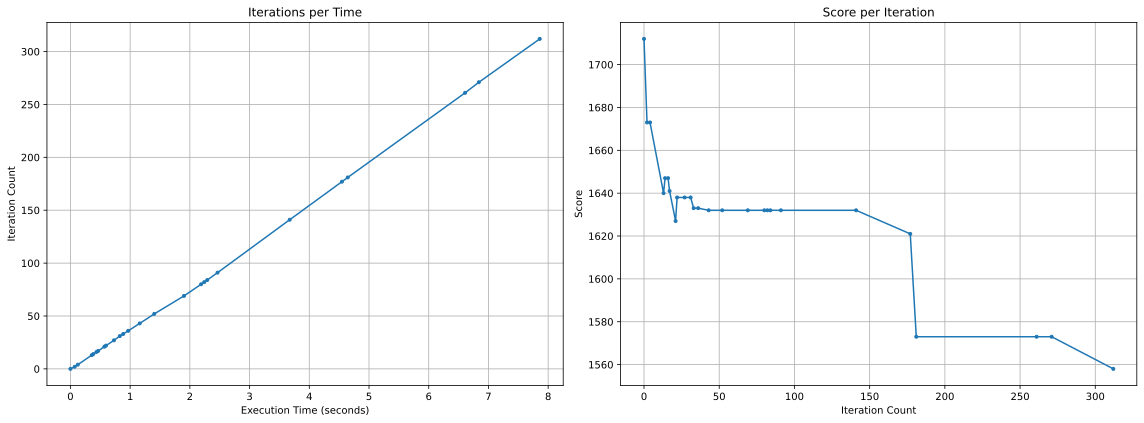

1558
{'all': 280, 'two': 142, 'one': 138, 't': 33}


In [ ]:
# 1. 初期グラフの生成
c = generate_H_S_CNOT_T_circuit(8, 500, p_t=0.08, seed=1000) 
c = pyzx.optimize.basic_optimization(c)
initial_graph = c.to_graph()
pyzx.simplify.spider_simp(initial_graph)
pyzx.simplify.to_gh(initial_graph)
pyzx.simplify.id_simp(initial_graph)

print("初期グラフが生成されました。")
initial_score = score(initial_graph)

# 2. 焼きなまし法の設定と実行
print("\n--- 焼きなまし法を開始 ---")
sa = SimulatedAnnealer2(
    initial_temp=10.0,
    final_temp=0.01,
    cooling_rate=0.98,
)

best_graph, best_score_result, score_history = sa.solve(
    initial_state=initial_graph,
    evaluate_func=score_t,
)

# 3. 結果の表示
print("\n--- 結果 ---")
print(f"初期スコア: {initial_score}")
print(f"最終的な最良スコア: {best_score_result}")

print("\n最適化後のグラフ:")
pyzx.draw(best_graph, labels=True)

# 4. 新しいグラフ描画関数を呼び出す
print("\n--- パフォーマンスグラフ ---")
plot_graphs2(score_history)
print(score(best_graph))
print(get_gate_num(best_graph))

In [17]:
#sa template

#define circuit
c = generate_H_S_CNOT_T_circuit(8, 1000, p_t=0.08, seed=1000) 

#pre proc
initial_graph = c.to_graph()
pyzx.simplify.spider_simp(initial_graph)
pyzx.simplify.to_gh(initial_graph)
pyzx.simplify.id_simp(initial_graph)


print("初期グラフが生成されました。")
initial_score = score_t(initial_graph)

# 2. 焼きなまし法の設定と実行
print("\n--- 焼きなまし法を開始 ---")
sa = SimulatedAnnealer2(
    initial_temp=10.0,
    final_temp=0.01,
    cooling_rate=0.98,
)

best_graph, best_score_result, score_history = sa.solve(
    initial_state=initial_graph,
    evaluate_func=score_t,
)

# 3. 結果の表示
print("\n--- 結果 ---")
print(f"初期スコア: {initial_score}")
print(f"最終的な最良スコア: {best_score_result}")

print("\n最適化後のグラフ:")
pyzx.draw(best_graph, labels=True)

# 4. 新しいグラフ描画関数を呼び出す
print("\n--- パフォーマンスグラフ ---")
plot_graphs2(score_history)
print(score(best_graph))
print(get_gate_num(best_graph))

spider_simp: 263. 158. 102. 52. 21. 6. 2. 3.  8 iterations
id_simp: 126. 24. 1.  3 iterations
初期グラフが生成されました。

--- 焼きなまし法を開始 ---
初期スコア: 58
温度更新: 9.8000, 現在スコア: 58, 最良スコア: 58
温度更新: 9.6040, 現在スコア: 58, 最良スコア: 58
温度更新: 9.4119, 現在スコア: 58, 最良スコア: 58
温度更新: 9.2237, 現在スコア: 58, 最良スコア: 58
温度更新: 9.0392, 現在スコア: 58, 最良スコア: 58
温度更新: 8.8584, 現在スコア: 58, 最良スコア: 58
温度更新: 8.6813, 現在スコア: 58, 最良スコア: 58
温度更新: 8.5076, 現在スコア: 58, 最良スコア: 58
温度更新: 8.3375, 現在スコア: 58, 最良スコア: 58
温度更新: 8.1707, 現在スコア: 58, 最良スコア: 58
温度更新: 8.0073, 現在スコア: 58, 最良スコア: 58
温度更新: 7.8472, 現在スコア: 58, 最良スコア: 58
温度更新: 7.6902, 現在スコア: 58, 最良スコア: 58
温度更新: 7.5364, 現在スコア: 58, 最良スコア: 58
温度更新: 7.3857, 現在スコア: 58, 最良スコア: 58
温度更新: 7.2380, 現在スコア: 58, 最良スコア: 58
温度更新: 7.0932, 現在スコア: 58, 最良スコア: 58
温度更新: 6.9514, 現在スコア: 58, 最良スコア: 58
温度更新: 6.8123, 現在スコア: 58, 最良スコア: 58
温度更新: 6.6761, 現在スコア: 58, 最良スコア: 58
温度更新: 6.5426, 現在スコア: 58, 最良スコア: 58
温度更新: 6.4117, 現在スコア: 58, 最良スコア: 58
温度更新: 6.2835, 現在スコア: 58, 最良スコア: 58
温度更新: 6.1578, 現在スコア: 58, 最良スコア: 58
温度更新: 6.0346, 現在スコア: 5

IndexError: list index out of range

In [143]:
c = generate_H_S_CNOT_T_circuit(12, 500, p_t=0.08, seed=1000) 
a = c.stats_dict() 
#print(c.stats_dict())
print(c.stats())
print(10* a["twoqubit"] + a["gates"] -a["twoqubit"] )
c = pyzx.optimize.basic_optimization(c)
a = c.stats_dict() 
#print(c.stats_dict())
print(10* a["twoqubit"] + a["gates"] -a["twoqubit"] )

g = c.to_graph()
pyzx.simplify.clifford_simp(g)
pyzx.draw(g, labels=True)
c = pyzx.extract.streaming_extract(g)
c = pyzx.optimize.basic_optimization(c)

a = c.stats_dict() 
#print(c.stats_dict())
print(10* a["twoqubit"] + a["gates"] -a["twoqubit"] )
print(c.stats())

Circuit  on 12 qubits with 500 gates.
        37 is the T-count
        463 Cliffords among which
        163 2-qubit gates (163 CNOT, 0 other) and
        156 Hadamard gates.
1967
1788


This function is deprecated. Call extract_circuit() instead.
2518
Circuit  on 12 qubits with 349 gates.
        27 is the T-count
        322 Cliffords among which
        241 2-qubit gates (106 CNOT, 135 other) and
        44 Hadamard gates.


In [ ]:
c = generate_H_S_CNOT_T_circuit(8, 1000, p_t=0.08, seed=1002)
g = c.to_graph()
pyzx.simplify.clifford_simp(g)
pyzx.draw(g, labels=True)

g2 = g.copy()
pyzx.draw(g2,labels=True)

from typing import Optional


In [86]:
c = generate_H_S_CNOT_T_circuit(8, 1000, p_t=0.08, seed=1002)
c2 = pyzx.optimize.basic_optimization(c)
c.verify_equality(c2)
c3 = pyzx.extract.streaming_extract(best_graph.copy())
c3 = pyzx.optimize.basic_optimization(c)
c3.verify_equality(c)

This function is deprecated. Call extract_circuit() instead.


True

In [ ]:
#op_t_mizeを使用可能
import pennylane as qml
import tempfile
[ds] = qml.data.load("op-t-mize")

pyzx_circuits = []
for i, qscript in enumerate(ds.circuits):
    try:
        # QuantumScript を OpenQASM 2.0 に変換
        qasm_str = qscript.to_openqasm(
            wires=None,             # 自動で wire を割り当て
            rotations=False,        # 観測のための回転ゲートを追加しない
            measure_all=False,      # 全量子ビットを測定しない（PyZXは測定非対応）
            precision=8             # パラメータ精度（省略可）
        )

        # QASM を一時ファイル経由で PyZX に読み込む
        with tempfile.NamedTemporaryFile(suffix=".qasm", mode='w+', delete=False) as tmpfile:
            tmpfile.write(qasm_str)
            tmpfile.flush()
            zx_circuit = pyzx.Circuit.load(tmpfile.name)

        pyzx_circuits.append(zx_circuit)

    except Exception as e:
        print(f"回路 {i}（{ds.circuit_names[i]}）の変換に失敗: {e}")


print(pyzx_circuits)


<Dataset = attributes: ['circuits', 'circuit_names', ...]>
[Circuit(5 qubits, 0 bits, 63 gates), Circuit(10 qubits, 0 bits, 150 gates), Circuit(15 qubits, 0 bits, 170 gates), Circuit(30 qubits, 0 bits, 448 gates), Circuit(24 qubits, 0 bits, 443 gates), Circuit(26 qubits, 0 bits, 884 gates), Circuit(36 qubits, 0 bits, 521 gates), Circuit(24 qubits, 0 bits, 900 gates), Circuit(14 qubits, 0 bits, 200 gates), Circuit(11 qubits, 0 bits, 278 gates), Circuit(9 qubits, 0 bits, 119 gates), Circuit(5 qubits, 0 bits, 45 gates), Circuit(7 qubits, 0 bits, 75 gates), Circuit(9 qubits, 0 bits, 105 gates), Circuit(19 qubits, 0 bits, 255 gates), Circuit(12 qubits, 0 bits, 243 gates), Circuit(15 qubits, 0 bits, 379 gates), Circuit(18 qubits, 0 bits, 545 gates), Circuit(21 qubits, 0 bits, 741 gates), Circuit(24 qubits, 0 bits, 981 gates), Circuit(27 qubits, 0 bits, 1223 gates), Circuit(30 qubits, 0 bits, 1509 gates), Circuit(48 qubits, 0 bits, 3885 gates), Circuit(5 qubits, 0 bits, 60 gates), Circuit(7 q